In [1]:
import os
import bitsandbytes as bnb
import pandas as pd
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from peft import (
    LoraConfig,
    PeftConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
  
# using the style for the plot 
plt.style.use('dark_background') 
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

In [2]:
model_id = "ai-forever/rugpt3large_based_on_gpt2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    load_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model =AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=bnb_config,
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

In [3]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [4]:
def print_trainable_parameters(model):
  """
  Prints the number of trainable parameters in the model.
  """
  trainable_params = 0
  all_param = 0
  for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
      trainable_params += param.numel()
  print(
      f"trainable params: {trainable_params} || all params: {all_param} || trainables%: {100 * trainable_params / all_param}"
  )

In [5]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1536)
    (wpe): Embedding(2048, 1536)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Linear4bit(in_features=1536, out_features=4608, bias=True)
          (c_proj): Linear4bit(in_features=1536, out_features=1536, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Linear4bit(in_features=1536, out_features=6144, bias=True)
          (c_proj): Linear4bit(in_features=6144, out_features=1536, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1536,), eps=1e-05, element

## Lora Config

In [6]:
config = LoraConfig(
    r=64,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 25952256 || all params: 446513664 || trainables%: 5.812197496379416


# Load Dataset (ru_instruct_gpt4)

In [6]:
def generate_prompt(data_point):
  return f"""
Task: {data_point["instruction"]}
Input: {data_point["input"]}
Output: {data_point["output"]}
""".strip()

In [7]:
data = load_dataset("lksy/ru_instruct_gpt4", split="train")
data = data.train_test_split(test_size=0.04)

/home/alm/miniforge3/envs/assistant_nlp/lib/python3.9/site-packages/datasets/load.py:1461: FutureWarning: The repository for lksy/ru_instruct_gpt4 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/lksy/ru_instruct_gpt4
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating train split: 100%|██████████| 15056/15056 [00:00<00:00, 26864.73 examples/s]


In [8]:
data

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'full_output'],
        num_rows: 14453
    })
    test: Dataset({
        features: ['instruction', 'input', 'output', 'full_output'],
        num_rows: 603
    })
})

## Few examples

In [10]:
for i in range(10):
    tmp = data["train"][i]
    print(generate_prompt(tmp))
    print("-----------------------------")

Task: Предложите романтическую локацию для первого свидания Максима и Юлии.
Input: Максим прививает розы, Юлия путешествует.
Output: Максим и Юлия могут провести свое первое свидание в живописном парке с розарием, который будет символизировать их общую страсть к красоте и путешествиям.
-----------------------------
Task: Сформулируй вопрос о недавно прочитанной книге, который бы сподвиг взрослого читателя прокомментировать свое восприятие книги.
Input: 
Output: Вам нравится протагонист книги "Тёмная башня", Роланд, и его мотивы в путешествии? Почему?
-----------------------------
Task: Оцените, будет ли положительное или отрицательное влияние на рынок недвижимости от государственного обновления закона об ипотеке, который планирует снижение ставки для молодых семей и увеличение субсидии на первый взнос.
Input: Государство обновляет закон об ипотеке: снижение ставки для молодых семей, увеличение субсидии на первый взнос.
Output: положительное
-----------------------------
Task: Расскажи 

In [11]:
ex_prompt = generate_prompt(tmp)
ex_prompt[ex_prompt.find("Output: ") + 8:]

'Более подходящие слова: могу оплатить'

# Prompt

In [9]:
def generate_and_tokenize_prompt(data_point):
  full_prompt = generate_prompt(data_point)
  tokenized_full_prompt = tokenizer(full_prompt, padding=True, truncation=True)
  return tokenized_full_prompt

train_data = data["train"].shuffle().map(generate_and_tokenize_prompt)
val_data = data["test"].shuffle().map(generate_and_tokenize_prompt)

Map: 100%|██████████| 603/603 [00:00<00:00, 1873.32 examples/s]


# Metrics setup and Training

In [13]:
import evaluate
import nltk

metric = evaluate.load('rouge')

# rouge
def rouge_custom(pred):
    references = pred.label_ids
    predictions = pred.predictions.argmax(axis=2)

    ref_sent = []
    pred_sent = []
    for ref, predicted in zip(references, predictions):
        # replace -100 with pad token
        ref[ref == -100] = tokenizer.eos_token_id
        ref_decoded = tokenizer.decode(ref, skip_special_tokens=True)
        predicted_decoded = tokenizer.decode(predicted, skip_special_tokens=True)
        sequence_start = ref_decoded.find("Output: ") + 8
        ref_sent.append(ref_decoded[sequence_start:])
        pred_sent.append(predicted_decoded[sequence_start:])

    return metric.compute(predictions=pred_sent, references=ref_sent)


def bleu_custom(pred):
    macro_bleu = 0
    references = pred.label_ids
    predictions = pred.predictions.argmax(axis=2)

    for ref, predicted in zip(references, predictions):
        # replace -100 with pad token
        ref[ref == -100] = tokenizer.eos_token_id
        ref_decoded = tokenizer.decode(ref, skip_special_tokens=True)
        predicted_decoded = tokenizer.decode(predicted, skip_special_tokens=True)
        sequence_start = ref_decoded.find("Output: ") + 8
        bleu_score = nltk.translate.bleu_score.sentence_bleu(
                [ref_decoded[sequence_start:]],
                predicted_decoded[sequence_start:],
                weights = [0.334, 0.333, 0.333]
        )   
        macro_bleu += bleu_score
    return {
        'bleu': macro_bleu / len(references)
    }

def rouge_bleu_custom(pred):
    references = pred.label_ids
    predictions = pred.predictions.argmax(axis=2)

    ref_sent = []
    pred_sent = []
    macro_bleu = 0
    for ref, predicted in zip(references, predictions):
        # replace -100 with pad token
        ref[ref == -100] = tokenizer.eos_token_id
        ref_decoded = tokenizer.decode(ref, skip_special_tokens=True)
        predicted_decoded = tokenizer.decode(predicted, skip_special_tokens=True)
        sequence_start = ref_decoded.find("Output: ") + 8
        ref_sent.append(ref_decoded[sequence_start:])
        pred_sent.append(predicted_decoded[sequence_start:])
        
        bleu_score = nltk.translate.bleu_score.sentence_bleu(
                [ref_decoded[sequence_start:]],
                predicted_decoded[sequence_start:],
                weights = [0.334, 0.333, 0.333]
        )
        macro_bleu += bleu_score
    metrics_dict = metric.compute(predictions=pred_sent, references=ref_sent)
    metrics_dict['bleu'] = macro_bleu / len(references)
    return metrics_dict

In [14]:
training_args = transformers.TrainingArguments(
      per_device_train_batch_size=6,
      per_device_eval_batch_size=1,
      gradient_accumulation_steps=4,
      eval_accumulation_steps=4,
      num_train_epochs=10,
      learning_rate=2e-4,
      fp16=True,
      save_total_limit=3,
      output_dir="experiments",
      optim="paged_adamw_8bit",
      lr_scheduler_type="cosine",
      warmup_ratio=0.05,
      logging_dir = './logs', # Каталог для хранения логов
      report_to = 'tensorboard',
      load_best_model_at_end = True, # Загружать ли лучшую модель после обучения
      evaluation_strategy ='epoch', #Валидация после каждой эпохи (можно сделать после конкретного кол-ва шагов)
      eval_steps=250,
      logging_strategy='steps', #Логирование после каждой эпохи
      logging_steps=1,
      save_strategy='epoch', #Сохранение после каждой эпохи
      save_steps=2000,
      seed=42,
)

trainer = transformers.Trainer(
    model=model,
    compute_metrics=rouge_bleu_custom,
    train_dataset=train_data,
    eval_dataset =val_data,
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=Tru

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu
0,1.844500,1.970574,0.145344,0.075589,0.142637,0.142328,0.589650
1,1.972700,1.919005,0.144560,0.080053,0.142858,0.142665,0.596444
2,1.921000,1.902533,0.148873,0.083316,0.146806,0.146785,0.596087
3,1.926300,1.899260,0.151533,0.086433,0.149386,0.149717,0.595376


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Checkpoint destination directory experiments/checkpoint-602 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The de

TrainOutput(global_step=2408, training_loss=2.090454618845667, metrics={'train_runtime': 5654.4372, 'train_samples_per_second': 10.224, 'train_steps_per_second': 0.426, 'total_flos': 3.81125582944727e+16, 'train_loss': 2.090454618845667, 'epoch': 4.0})

## Check Model

In [1]:
import os
import bitsandbytes as bnb
import pandas as pd
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
  
# using the style for the plot 
plt.style.use('dark_background') 
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

/home/alm/miniforge3/envs/assistant_nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    load_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

In [3]:
PEFT_MODEL = "models/gpt2/rugpt3large_based_on_gpt2"

config = PeftConfig.from_pretrained(PEFT_MODEL)
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
)

tokenizer=AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token


In [4]:
model = PeftModel.from_pretrained(model, PEFT_MODEL)

(array([3.629e+03, 3.325e+03, 3.546e+03, 2.617e+03, 1.030e+03, 2.240e+02,
        5.800e+01, 1.700e+01, 6.000e+00, 1.000e+00]),
 array([1.0000e+00, 1.4420e+02, 2.8740e+02, 4.3060e+02, 5.7380e+02,
        7.1700e+02, 8.6020e+02, 1.0034e+03, 1.1466e+03, 1.2898e+03,
        1.4330e+03]),
 <BarContainer object of 10 artists>)

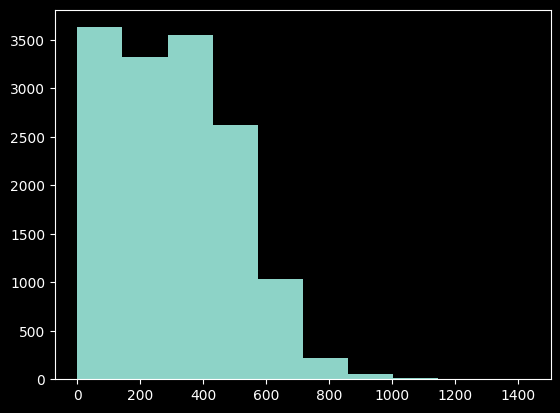

In [10]:
output_len = []

for i in range(len(train_data)):
    output_len.append(len(train_data["output"][i]))
plt.hist(output_len)

In [13]:
print(f"Median of Train Output Len: {np.median(output_len)}")
print(f"Mean of Train Output Len: {np.mean(output_len):.2f}")

Median of Train Output Len: 297.0
Mean of Train Output Len: 307.10


In [29]:
# Параметры для генерации
generation_params = {
    "max_new_tokens": 150,
    "num_beams": 3,
    "early_stopping": True,
    "no_repeat_ngram_size": 2,
    "eos_token_id": tokenizer.eos_token_id,
    "pad_token_id": tokenizer.eos_token_id,
}

## Рассмотрим обработку текстов из валидационного датасета

In [30]:
for _ in range(10):
  i = np.random.randint(len(val_data))
  prompt = f"""
  Task: {val_data["instruction"][i]}
  Input: {val_data["input"][i]}
  Output:
  """.strip()

  original_prompt = f"""
  Task: {val_data["instruction"][i]}
  Input: {val_data["input"][i]}
  Output: {val_data["output"][i]}
  """.strip()

  device = "cuda:0"
  encoding = tokenizer(prompt, return_tensors="pt").to(device)
  with torch.inference_mode():
    outputs = model.generate(
        input_ids = encoding.input_ids,
        attention_mask = encoding.attention_mask,
        **generation_params,
  )
  pred_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
  # sequence_start = pred_text.find("Output: ") + 8
  print(pred_text)
  print("---------------------------------")
  print("Validation Output: " + val_data["output"][i])
  print("\n\n")

Task: Создай описание сказочного героя с учетом его характеристик и способностей.
  Input: Бармило - маленький добрый гном
  Output: В далеком королевстве жил маленький гном по имени Бармилло. Он был очень добрым и отзывчивым, всегда помогал людям и животным. Однажды, когда он отправился на поиски сокровищ, он столкнулся с коварным злодеем, который хотел завладеть его сокровищами. Вместе они смогли победить злодея и вернуть сокровища в королевство. Благодаря своей доброте и умению ладить с другими гномами, они стали настоящими друзьями и защитниками королевства. В благодарность за это, король наградил Бармила своим титулом и дал ему возможность жить и работать в своем родном городе. С тех пор гном стал настоящим героем и примером для подражания для других гномов. Его мудрость и доброта вдохновляют их на добрые дела и помогают им стать лучше и счастливее. Бар
---------------------------------
Validation Output: Бармило - маленький добрый гном, известный своей храбростью и остроумием. У 

In [31]:
# Можно заметить, что модель в целом осознанная, но иногда бывает ее заносит в какие-то частные случаи, которые, видимо встречались в исходной тренировочной выборке